## Homework 4 - Recommendation systems and clustering everywhere

## 1. Recommendation sytem

The goal of the initial exercise is to develop a recommendation system. This system takes a user's input, identifies users with similar preferences, and suggests the most-watched movies among users that match the user's tastes.

In [1]:
import pandas as pd
import numpy as np

# Read the CSV dataset into a Pandas DataFrame
df = pd.read_csv('vodclickstream_uk_movies_03.csv') 

# Transform the 'datetime' column using the datetime library, handling non-valid datetimes
df.datetime = pd.to_datetime(df.datetime, errors='coerce')

# Transform the 'release_date' column using the datetime library, handling non-valid dates
df.release_date = pd.to_datetime(df.release_date, errors='coerce')  

# Convert the 'genres' column from a string of genres separated by commas to a list of values
df['genres'] = df['genres'].str.split(',')

# Set the values in the first column as indices
df.set_index(df.columns[0], inplace=True)

In [113]:
df.head(5) # print the first entries of the dataframe

,Unnamed: 0,datetime,duration,title,genres,release_date,movie_id,user_id
0,58773,2017-01-01 01:15:09,0.0,"Angus, Thongs and Perfect Snogging","[Comedy, Drama, Romance]",2008-07-25,26bd5987e8,1dea19f6fe
1,58774,2017-01-01 13:56:02,0.0,The Curse of Sleeping Beauty,"[Fantasy, Horror, Mystery, Thriller]",2016-06-02,f26ed2675e,544dcbc510
2,58775,2017-01-01 15:17:47,10530.0,London Has Fallen,"[Action, Thriller]",2016-03-04,f77e500e7a,7cbcc791bf
3,58776,2017-01-01 16:04:13,49.0,Vendetta,"[Action, Drama]",2015-06-12,c74aec7673,ebf43c36b6
4,58777,2017-01-01 19:16:37,0.0,The SpongeBob SquarePants Movie,"[Animation, Action, Adventure, Comedy, Fam...",2004-11-19,a80d6fc2aa,a57c992287


Create a new dataframe that collects, for each user, his 10 favorite movies and genres based on the number of clicks. The resulting dataframe should consist of three columns: one for the user ID, another for the list of his (up to) 10 favorite movies, and the last for the list of his favorite genres (corresponding to the genres of his favorite movies).

In [3]:
# STEP 1: GET TOP_10 MOVIES FOR EACH USER 

# Group the DataFrame by 'user_id' and 'title', then calculate the size (number of occurrences) of each group
movie_counts = df.groupby(['user_id', 'title']).size().reset_index(name='movie_count')

# Sort the movie_counts DataFrame by 'movie_count' in descending order and select the top 10 movies for each user
top_movies = movie_counts.sort_values(by='movie_count', ascending=False).groupby('user_id').head(10).reset_index(drop=True)

# Group the top_movies DataFrame by 'user_id' and aggregate the titles into a list
top_movies = top_movies.groupby('user_id')['title'].agg(list).reset_index()



# STEP 2: GET GENRES OF THE TOP 10 MOVIES FOR EACH USER

# Explode the 'genres' column so that each row contains a single genre
exploded_genres = df.explode('genres')

# Remove "NOT AVAILABLE" values from the 'genres' column and apply strip() to remove spaces
exploded_genres = exploded_genres[exploded_genres['genres'] != 'NOT AVAILABLE']
exploded_genres['genres'] = exploded_genres['genres'].str.strip()

# Filter the exploded_genres DataFrame to include only genres for the top_movies
top_genres = exploded_genres[exploded_genres['title'].isin(top_movies.explode('title')['title'])]

# Group the top_genres DataFrame by 'user_id', aggregate the genres into a set (to remove duplicate values), and transform the set into a sortedlist
top_genres = top_genres.groupby('user_id')['genres'].agg(set).reset_index()
top_genres['genres'] = top_genres['genres'].apply(list)
top_genres['genres'] = top_genres['genres'].apply(lambda x: sorted(x))



# STEP 3: Merge the two DataFrames on the 'user_id' column values

result_df = pd.merge(top_movies, top_genres, on='user_id')
result_df = result_df.rename(columns={'title': 'top_movies', 'genres': 'favorite_genres'})


In [111]:
result_df.head(10) # print the first entries of the result_df

,user_id,top_movies,favorite_genres
0,00004e2862,[Hannibal],"[Crime, Drama, Thriller]"
1,000052a0a0,"[Looper, Frailty, Jumanji, Resident Evil, The ...","[Action, Adventure, Animation, Comedy, Crime, ..."
2,000090e7c8,[Mute],"[Mystery, Sci-Fi, Thriller]"
3,000118a755,"[From Dusk till Dawn (franchise), The Omen]",[Horror]
4,000296842d,[Black Mirror: Bandersnatch],"[Drama, Mystery, Sci-Fi, Thriller]"
5,0002aab109,"[The Iron Lady, King Cobra, 127 Hours]","[Biography, Comedy, Crime, Drama]"
6,0002abf14f,[Fifty Shades Darker],"[Drama, Romance]"
7,0002d1c4b1,[Hot Bot],"[Comedy, Sci-Fi]"
8,000499c2b6,[Flushed Away],"[Adventure, Animation, Comedy, Family, Fantasy]"
9,00051f0e1f,[Ant-Man],"[Action, Adventure, Comedy, Sci-Fi]"


### 1.2 **Minhash Signatures**

For the implementation of the preference matrix, I used a pandas DataFrame. Each row of the DataFrame corresponds to a user, uniquely identified by its user_id used as an index. The columns, on the other hand, represent different genres. If a user has a particular genre among his favorites, the corresponding value in the column will be 1, otherwise it will be 0

In [5]:

# Extract the list of all the genres and sort them in alphabetical order
genres = {genre for genres in result_df['favorite_genres'] for genre in genres}
genres = sorted(genres)

# Extract the list of all the users ids
users = list(result_df.user_id)

# Create a DataFrame with all the genres as columns and users id as rows' indexes
preference_matrix = pd.DataFrame(0, index=users, columns=genres)

# Iterate through each row in the original DataFrame
for index, row in result_df.iterrows():
    user_id = row['user_id']
    user_genres = row['favorite_genres']
    
    # Set to 1 the columns corresponding to the favorite genres of the user
    preference_matrix.loc[user_id, user_genres] = 1

    

In [110]:
preference_matrix.head(10) # print the first entries of the preference_matrix

,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,Fantasy,...,News,Reality-TV,Romance,Sci-Fi,Short,Sport,Talk-Show,Thriller,War,Western
00004e2862,0,0,0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
000052a0a0,1,1,1,0,1,1,0,1,1,1,...,0,0,0,1,0,1,0,1,0,0
000090e7c8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
000118a755,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
000296842d,0,0,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,1,0,0
0002aab109,0,0,0,1,1,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
0002abf14f,0,0,0,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
0002d1c4b1,0,0,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
000499c2b6,0,1,1,0,1,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
00051f0e1f,1,1,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In the code below, we use the MinHash algorithm to generate unique signatures representing users' preferences for genres. The MinHash algorithm is known to estimate Jaccard similarity between sets, and in this context, we exploit it to approximate users' similarity based on their preferred genres. 

We first create a function to generate a set of random hash functions, which are essential for computing MinHash. Next, another function computes MinHash signatures based on binary vectors representing users' gender preferences. With a specific number of hash functions and the total number of genres, the code generates MinHash signatures for each user in a given preference matrix. These signatures are stored in a dictionary, associating each user ID with the corresponding MinHash signature.

In [41]:
import random

# Function to generate a list of random costants to use in the hash functions
def generate_hash_functions(num_hashes):
    hash_functions = [] # initialize an empty list

    for _ in range(num_hashes):
        # Generate random values 'a' and 'b' for the hash function
        a = random.randint(1, 100)
        b = random.randint(0, 100)

        # Append the tuple (a, b) representing the hash function to the list
        hash_functions.append((a, b))

    return hash_functions


# Function to calculate the MinHash signature based on user's preferences
def calculate_signature(user_preferences, num_hashes, num_genres, hash_functions):
    # Initialize the MinHash signature as a list of 'num_hashes' elements with values set to infinity
    signature = [float('inf')] * num_hashes  

    # Iterate through each genre in the user's preferences
    for genre_index, is_favorite in enumerate(user_preferences):
        
        # Update the MinHash signature based on the hash values calculated for each hash function
        for j, hash_function in enumerate(hash_functions):
            a, b = hash_function

            # Chosen hash function: h_j = (a * genre_index * is_favorite + b) mod num_genres
            hash_value = (a * genre_index * is_favorite + b) % num_genres

            # Update the MinHash signature with the minimum value between the existing value (inf) and the new hash value
            signature[j] = min(signature[j], hash_value)

    return signature

# Set the number of hash functions and calculate the number of genres
num_hashes = 20
num_genres = len(genres)

# Generate random hash functions using the 'generate_hash_functions' function
hash_functions = generate_hash_functions(num_hashes)

# Calculate MinHash signatures for each user's preferences in 'preference_matrix'
signatures = {}
for user_id, user_preferences in preference_matrix.iterrows():
    signature = calculate_signature(user_preferences, num_hashes, num_genres, hash_functions)
    signatures[user_id] = signature

# Transform the dictionary into a pandas Dataframe
signatures_df = pd.DataFrame(list(signatures.items()), columns=['user_id', 'signature'])


In [42]:
signatures_df.head() # Show the first entries of the signature dataframe


,user_id,signature
0,00004e2862,"[4, 1, 8, 2, 3, 0, 3, 6, 21, 4, 11, 1, 4, 0, 5..."
1,000052a0a0,"[0, 1, 0, 0, 1, 0, 3, 6, 21, 0, 3, 0, 4, 0, 1,..."
2,000090e7c8,"[8, 1, 0, 0, 5, 0, 5, 6, 21, 0, 15, 1, 7, 0, 7..."
3,000118a755,"[0, 7, 9, 16, 7, 4, 4, 19, 21, 11, 14, 0, 7, 0..."
4,000296842d,"[4, 1, 0, 0, 3, 0, 5, 6, 21, 0, 15, 1, 4, 0, 5..."


### 1.3 Locality-Sensitive Hashing (LSH)


In this code, we have implemented a Locality-Sensitive Hashing (LSH) algorithm to efficiently identify similar users based on their MinHash signatures. The algorithm organizes users into buckets, where each bucket corresponds to a MinHash signature band. Users with similar signatures, reflecting shared preferences, are grouped within the same buckets.<br>
The buckets are stored in a dictionary, where the key is represented by a tuple (containing the band values), and the value is a list containing all the user_ids stored in that bucket.

In [43]:
from collections import defaultdict

def LSH(signatures, num_hashes, num_bands):
    # the number of rows per band is the number of hash values in each band of the MinHash signature, and it is determined by the total number of hash functions and the desired number of bands
    num_rows_per_band = num_hashes // num_bands

    # Create a dictionary to store the buckets
    buckets = defaultdict(list)

    # Assign Users to Buckets: 
    for user_id, signature in signatures.items():
        for band_index in range(num_bands):
            # Determine the start and end indices for the current band
            band_start = band_index * num_rows_per_band
            band_end = (band_index + 1) * num_rows_per_band

            # Extract the band from the MinHash signature and convert it to a tuple
            band = tuple(signature[band_start:band_end])

            # Append the user to the corresponding bucket based on the band value
            buckets[band].append(user_id)

    return buckets


In [44]:
# initialize the buckets dictionary
buckets = LSH(signatures, num_hashes, num_bands=5) # we use 5 bands, so each band contains 4 hash values and the dictonary has tuples of 4 values as keys

# Print the count of buckets that have been created
print(len(buckets))

1827


Now we define a function that, given a user_id as input, retrieves the ids of the 2 most similar users. To achieve this, we first collect all the buckets containing the query user_id and store them in a list. Then, we extract all the user_ids (different from the query) from the newly created list and create a new list of all the users.
<br>
The second step involves creating a Counter, which counts the number of occurrences of each user in the list. The users that occur the most times, corresponding to users who appear with the query user in more buckets, are then returned by the function. These users are considered the most similar based on genre preferences.

In [48]:
from collections import Counter

def find_most_similar_users(user_id, num_similar_users=2):
    # Put in a list all the user_ids contained in the buckets in which the query user_id appears
    user_buckets = [bucket for bucket in buckets.values() if user_id in bucket]
    
    if not user_buckets: # handle the case where user_id doen't exist
        print("User not found in any bucket")
        return None

    # Flatten the list of buckets to get all users in the specified buckets
    all_users = [user for bucket in user_buckets for user in bucket if user != user_id]

    # Count occurrences of users in the specified buckets
    user_occurrences = Counter(all_users)

    # Sort occurrences in descending order
    sorted_user_occurrences = user_occurrences.most_common(num_similar_users)
    return sorted_user_occurrences

This "get_recommendations" function calls the previous function to obtain the 2 most similar users with respect to the user provided as input. Once the user_ids of these two users are obtained, we proceed to extract lists of their favorite movies. Next, we count the number of clicks for each movie and store this information in two new dataframes. These dataframes are then merged together.
<br>
In the final step, we extract the list of common movies (intersection) and the unique movie lists for the first and second users. The titles are then compiled into a list following a specific order:

- First, common movies are listed, recommended based on the total number of clicks by these users.
- If there are no more common movies, an attempt is made to suggest first the movies most clicked by the most similar user, followed by the other user.

The resulting list is truncated to 5 items to retrieve (up to) 5 titles for recommendation.

In [49]:
def get_recommendations(user_id):

    query_user = user_id
    similar_users = find_most_similar_users(query_user, 2)  # Retrieve the top 2 most similar users

    if similar_users is None:
        return None

    
    # Extract user_id of the two most similar users (the second 0 represents the id ; 1 for the counts)
    user_1 = similar_users[0][0]
    user_2 = similar_users[1][0]

    # Get the lists of favorite movies of the two users from the dataframe created previously
    movies_user_1 = result_df[result_df['user_id'] == user_1]['top_movies'].values[0]
    movies_user_2 = result_df[result_df['user_id'] == user_2]['top_movies'].values[0]

    # Create DataFrames with user_id and corresponding movie titles
    df_user_1 = pd.DataFrame({'user_id': [user_1] * len(movies_user_1), 'title': movies_user_1})
    df_user_2 = pd.DataFrame({'user_id': [user_2] * len(movies_user_2), 'title': movies_user_2})


    # Count occurrences using groupby for df_user_1
    df_user_1['#clicks'] = df.groupby(['user_id', 'title']).size().reset_index(name='#clicks')['#clicks']
    # Count occurrences using groupby for df_user_2
    df_user_2['#clicks'] = df.groupby(['user_id', 'title']).size().reset_index(name='#clicks')['#clicks']


    # Concatenate the two DataFrames vertically and print the dataframe
    final_df = pd.concat([df_user_1, df_user_2], ignore_index=True)
    print(final_df)
    print("---------------------------------------------------------\n")

    # Identify common movies and sort them based on the sum of clicks
    common_movies = set(final_df[final_df['user_id'] == user_1]['title']).intersection(set(final_df[final_df['user_id'] == user_2]['title']))
    
    # Sort the title base on the sum of clicks
    sorted_common_movies = sorted(common_movies, key=lambda title: final_df[final_df['title'] == title]['#clicks'].sum(), reverse=True)

    # Extract unique titles for each user, sorted by clicks
    user1_unique_movies = sorted(
    list(set(final_df[final_df['user_id'] == user_1]['title']) - common_movies),
    key=lambda title: final_df[final_df['title'] == title]['#clicks'].sum(),
    reverse=True
    )

    user2_unique_movies = sorted(
    list(set(final_df[final_df['user_id'] == user_2]['title']) - common_movies),
    key=lambda title: final_df[final_df['title'] == title]['#clicks'].sum(),
    reverse=True
    )
    
    # Build the final recommendation list by combining the three lists
    final_list = sorted_common_movies + user1_unique_movies + user2_unique_movies
    final_list = final_list[:5]  # Take only the first 5 titles

    # Print the final list with rankings
    print("Recommended movies:")
    for i, title in enumerate(final_list):
        print(i + 1, title)


In the following section, we provide an illustrative example of the function's usage. We deliberately selected a user ID with a large list of movies, which results in a sufficiently long genre selection.<br>
As it turns out, the two most similar users retrieved show exactly the same genre preferences as the queried user. This commonality is reflected in their signatures, indicating a common taste in movie genres.<br>


We observe that the two most similar users share two movies in common. Consequently, these two movies, namely 'La La Land' and 'Madagascar,' are prioritized in the recommendation list. Subsequently, to finalize the compilation of the list, three additional movies from the first user are selected, based on the number of clicks in descending order.


In [50]:
# Try the function 
get_recommendations('01abe4be26')

       user_id                            title  #clicks
0   0156f19db0                           Hunger        1
1   0156f19db0                           Bright        1
2   0156f19db0  The Hunger Games: Catching Fire        1
3   0156f19db0              Shrek Forever After        3
4   0156f19db0      Madagascar: Escape 2 Africa        1
5   0156f19db0                       Madagascar        3
6   0156f19db0                       La La Land        9
7   0156f19db0                        John Wick        2
8   198b2a78b1        Hunt for the Wilderpeople        1
9   198b2a78b1                            Shrek        1
10  198b2a78b1                    The Interview        1
11  198b2a78b1              The Young Offenders        3
12  198b2a78b1         The Shawshank Redemption        1
13  198b2a78b1                    The Nice Guys        3
14  198b2a78b1                   The Full Monty        9
15  198b2a78b1                             Okja        2
16  198b2a78b1                 

In [51]:
signatures_df[signatures_df['user_id'].isin(["01abe4be26", "0156f19db0", "198b2a78b1"])]

,user_id,signature
842,0156f19db0,"[2, 1, 0, 0, 1, 0, 3, 6, 21, 0, 0, 1, 1, 0, 1,..."
1048,01abe4be26,"[2, 1, 0, 0, 1, 0, 3, 6, 21, 0, 0, 1, 1, 0, 1,..."
15726,198b2a78b1,"[2, 1, 0, 0, 1, 0, 3, 6, 21, 0, 0, 1, 1, 0, 1,..."


In [52]:
result_df[result_df['user_id'].isin(["01abe4be26", "0156f19db0", "198b2a78b1"])]

,user_id,top_movies,favorite_genres
842,0156f19db0,"[Hunger, Bright, The Hunger Games: Catching Fi...","[Action, Adventure, Animation, Biography, Come..."
1048,01abe4be26,"[The Week Of, 30 Minutes or Less, Adrift, Limi...","[Action, Adventure, Animation, Biography, Come..."
15726,198b2a78b1,"[Hunt for the Wilderpeople, Shrek, The Intervi...","[Action, Adventure, Animation, Biography, Come..."


## 2. Grouping Users together!

Now, we will deal with clustering algorithms that will provide groups of Netflix users that are similar among them.

### 2.1 Getting your data + feature engineering

1. Access to the data

In [68]:
df = pd.read_csv('vodclickstream_uk_movies_03.csv')

2. Sometimes, the features (variables, fields) are not given in a dataset but can be created from it; this is known as feature engineering. For example, the original dataset has several clicks done by the same user, so grouping data by user_id will allow you to create new features for each user:

a) Favorite genre:<br>

We begin with the favourite genre of the user. For this we are going to do a quick search, separating the genre columns in a string a creating a new row for each genre. Then search for the one who has te most cumulative duration.

In [69]:
df_final = df 

# We split and create a new row for each genre with explode
df_final['genres'] = df_final['genres'].astype(str).str.split(',')
exploded_df = df_final.explode('genres')

# We convert the genres to lowercase and strip them
exploded_df['genres'] = exploded_df['genres'].str.lower().str.strip()

# We group by user_id and genres and we get the sum of duration
group_df = exploded_df.groupby(['user_id', 'genres'])['duration'].sum().reset_index()

# We find the genre with the longest duration for each user
idx = group_df.groupby('user_id')['duration'].idxmax()
favorite_genre = group_df.loc[idx, ['user_id', 'genres']].reset_index(drop=True)
favorite_genre.columns = ['user_id', 'favorite_genre']

df_final = pd.merge(df, favorite_genre, on='user_id', how='left')


b) Average click duration:<br>

Here we are going to group by user_id and then calculate the mean of the duration

In [70]:
mean_duration = df.groupby('user_id')['duration'].mean() # We use the gorupby and mean function
df_average_duration = mean_duration.reset_index(name='average_click_duration')

df_final = pd.merge(df_final, df_average_duration, on='user_id', how='left') # we merge the new values


c) Time of the day (Morning/Afternoon/Night) when the user spends the most time on the platform (the time spent is tracked through the duration of the clicks)

For this we first convert datetime to only get the hour of the day, and the we create the time of the day it belongs.

In [71]:
# We convert 'datetime' to datetime format
df_final['hour_of_day'] = pd.to_datetime(df_final['datetime'])

# We extract the time from the 'datetime' column
df_final['hour_of_day'] = df_final['hour_of_day'].dt.time

We will define the morning from 6 am to 12 pm, the afternoon from 12pm to 7 pm, and the night from 7 pm to 6 am.

In [72]:
# We extract the hour and create the time of day for each click.
df_final['time_of_day'] = pd.cut(df_final['hour_of_day'].apply(lambda x: x.hour), bins=[0, 6, 12, 19, 24], labels=['Night', 'Morning', 'Afternoon', 'Night'], right=False, ordered=False)

Once we have this information we need to see wich one is the one the user spent the most time. For this we do like we did before for favorite genre and we get the one with the highest sum value.

In [73]:
# We group by user_id and times of day and we get the sum of duration
group_td = df_final.groupby(['user_id', 'time_of_day'])['duration'].sum().reset_index()

# We find the genre with the longest duration for each user
idx = group_td.groupby('user_id')['duration'].idxmax()
most_spent = group_td.loc[idx, ['user_id', 'time_of_day']].reset_index(drop=True)
most_spent.columns = ['user_id', 'tod_most_spent']
df_final = pd.merge(df_final, most_spent, on='user_id', how='left') # we merge the new values


d) Is the user an old movie lover, or is he into more recent stuff (content released after 2010)?<br>

For this one we define first a new column where if the release date is posterior to the 2000 it will be define as recent (1) and if its anterior it will be defined as old (0).

In [74]:
# We Convert 'release_date' to datetim
df_final['release_date'] = pd.to_datetime(df_final['release_date'], errors='coerce')

# We create 'is_recent' column based on the release date
df_final['recent_movie'] = (df_final['release_date'].dt.year >= 2000).astype(int)


Now we group by user and by recent movie and we sum the duration as we did before.

In [75]:
# We group by user_id and times of day and we get the sum of duration
group_rm = df_final.groupby(['user_id', 'recent_movie'])['duration'].sum().reset_index()

# We find the genre with the longest duration for each user
idx = group_rm.groupby('user_id')['duration'].idxmax()
old_new_lover = group_rm.loc[idx, ['user_id', 'recent_movie']].reset_index(drop=True)
old_new_lover.columns = ['user_id', 'old/new_movie_lover']
df_final = pd.merge(df_final, old_new_lover, on='user_id', how='left') # we merge the new values


Here the first five are recent movie lover

e) Average time spent a day by the user (considering only the days he logs in)<br>

For this feature we will get first the date and get the mean duration by user id and by date

In [76]:
# We convert datetime to datetime format
df_final['datetime'] = pd.to_datetime(df_final['datetime'])

# We extract the date from datetime
df_final['date'] = df_final['datetime'].dt.date


Now we group and get the mean by date

In [77]:
mean_tpd = df_final.groupby(['user_id', 'date'])['duration'].sum().groupby('user_id').mean()
df_mean_tpd = mean_tpd.reset_index(name='average_tpd')

df_final = pd.merge(df_final, df_mean_tpd, on='user_id', how='left') # we merge the new values


Lets take a look t our results

In [78]:
df_final.head()

,Unnamed: 0,datetime,duration,title,genres,release_date,movie_id,user_id,favorite_genre,average_click_duration,hour_of_day,time_of_day,tod_most_spent,recent_movie,old/new_movie_lover,date,average_tpd
0,58773,2017-01-01 01:15:09,0.0,"Angus, Thongs and Perfect Snogging","[Comedy, Drama, Romance]",2008-07-25,26bd5987e8,1dea19f6fe,comedy,0.000000,01:15:09,Night,Afternoon,1,1,2017-01-01,0.000000
1,58774,2017-01-01 13:56:02,0.0,The Curse of Sleeping Beauty,"[Fantasy, Horror, Mystery, Thriller]",2016-06-02,f26ed2675e,544dcbc510,drama,1553.750000,13:56:02,Afternoon,Night,1,1,2017-01-01,18645.000000
2,58775,2017-01-01 15:17:47,10530.0,London Has Fallen,"[Action, Thriller]",2016-03-04,f77e500e7a,7cbcc791bf,action,4218.666667,15:17:47,Afternoon,Afternoon,1,1,2017-01-01,8437.333333
3,58776,2017-01-01 16:04:13,49.0,Vendetta,"[Action, Drama]",2015-06-12,c74aec7673,ebf43c36b6,action,1883.533333,16:04:13,Afternoon,Afternoon,1,1,2017-01-01,9417.666667
4,58777,2017-01-01 19:16:37,0.0,The SpongeBob SquarePants Movie,"[Animation, Action, Adventure, Comedy, Fam...",2004-11-19,a80d6fc2aa,a57c992287,drama,3684.538462,19:16:37,Night,Afternoon,1,1,2017-01-01,7369.076923


Now we have 5 new features for each user_id.  This will probably help us to understand the behavior of the users and group them. But it's not enough yet.

We do have some more that we will eliminate later. But we will keep them for the moment since we are going to use them for the next features engineering.

##### Consider at least 10 additional features that can be generated for each user_id (you can use chatGPT or other LLM tools for suggesting features to create). Describe each of them and add them to the previous dataset you made (the one with five features). In the end, you should have for each user at least 15 features (5 recommended + 10 suggested by you).

1st one: Total different shows watched (more than 5 minutes of duration).

We should groub by all the users and different tiltes, sum the duration and make a count.

In [79]:

# We group 'user_id' and 'title', and calculate the total 'duration' 
group_ws = df_final.groupby(['user_id', 'title'])['duration'].sum().reset_index()

# We select the rows where the total 'duration' for each user and title is greater than 300
filtered_df = group_ws[group_ws['duration'] > 300]

# We count the number of unique 'title' values for each user
total_watched_count_shows = filtered_df.groupby('user_id')['title'].nunique().reset_index(name='watched_shows')

df_final = pd.merge(df_final, total_watched_count_shows, on='user_id', how='left')


We have to fill the NaN with 0 values.

In [80]:
df_final['watched_shows'] = df_final['watched_shows'].fillna(0)

2nd features: Total different shows.

We can do the same with all the different shows clicked, so we can compare them with the watched one.

This one is easier, we just have to count the diferrent title values for each user.

In [81]:
total_movies_count = df_final.groupby('user_id')['title'].nunique().reset_index(name='total_shows')

df_final = pd.merge(df_final, total_movies_count, on='user_id', how='left')



3rd feature: different genres clicked

Lets now get the different genres the user has clicked. We will use the nunique function that will get all the different genres for one user.

We are going to use the exploded_df we use for the prefered genre.

In [82]:
dif_genres = exploded_df.groupby('user_id')['genres'].nunique().reset_index(name='dif_genres')
dif_genres

,user_id,dif_genres
0,00004e2862,3
1,000052a0a0,14
2,000090e7c8,3
3,000118a755,2
4,000296842d,4
...,...,...
161913,fffd9bf758,3
161914,fffe7b777b,3
161915,fffeac83be,9
161916,ffff2c5f9e,5


In [83]:
df_final = pd.merge(df_final, dif_genres, on='user_id', how='left')


4th feature: Average release year of the clicked shows

Lets see what  is the average year of the shows seen by each user. For this we are going to group by user and release date, and get the mean of all the releases fromm the movies and shows clicked by the user.

In [84]:

average_release_year = df_final.groupby('user_id')['release_date'].agg(lambda x: np.floor(x.dt.year.mean())).reset_index(name='average_release_year')

df_final = pd.merge(df_final, average_release_year, on='user_id', how='left')


5th feature: different days active.

Here we are going to get all the days the user has connected to netflix during this period.

We are just going to count the differents dates as we did with the different genres.

In [85]:
days_active = df_final.groupby('user_id')['date'].nunique().reset_index(name='days_active')

df_final = pd.merge(df_final, days_active, on='user_id', how='left')


6th feature: most clicked genre.

We do as for the most favorite but we don't sum the duration, we count the times it appears.

In [86]:

most_clicked_genre = exploded_df.groupby('user_id')['genres'].agg(lambda x: x.value_counts().idxmax()).reset_index(name='most_clicked_genre')


df_final = pd.merge(df_final, most_clicked_genre, on='user_id', how='left')



7th feature: preffered day of the week

Here we are going to see what is the day of the week the user watch modt of the shows. 

We are going to group by date and user id, and sum the duration for each week day. This way we will know wich one has the longest duration and the one the user spends most of the time.

In [87]:
# we convert date to datetime format
df_final['date'] = pd.to_datetime(df_final['date'])

# We group by user and the day name of the date summing the durations
group_day = df_final.groupby(['user_id', df_final['date'].dt.day_name()])['duration'].sum().reset_index()

# We find the index with the maximum duration for each user_id
max_duration_idx = group_day.groupby('user_id')['duration'].idxmax()

# We use the indices to get the corresponding day names
preferred_day = group_day.loc[max_duration_idx, ['user_id', 'date']]

# We rename the columns
preferred_day.columns = ['user_id', 'preferred_day']

df_final = pd.merge(df_final, preferred_day, on='user_id', how='left')


8th feature: average time between clicks.

Lets see how long it takes the users to click. This way we will know which one are the one that use more the product.

We first have to get the time between consecutif clicks

In [88]:
df_final['time_between_clicks'] = df_final.sort_values(['user_id', 'datetime']).groupby('user_id')['datetime'].diff().dt.total_seconds()


Now that we have the time between clicks we can calculate the mean by making a group by user_id and time_between_clicks

In [89]:
mean_t_between_clicks = df_final.groupby('user_id')['time_between_clicks'].mean().reset_index(name='average_t_between_clicks')

df_final = pd.merge(df_final, mean_t_between_clicks, on='user_id', how='left')


We don't forget to fill the NaN values

In [90]:
df_final['average_t_between_clicks'] = df_final['average_t_between_clicks'].fillna(0)

9th feature: Weekend viewer

With this feature we will see if the user is more of a weekend user or of a week day user.

In [91]:
df_final['weekend_viewer'] = df_final['preferred_day'].isin(['Saturday', 'Sunday']).astype(int)


10th feature: total duration 

Here we will get the total duration of the users, so we can compare them.

We will just sum the duration for each user.

In [92]:
df_final['total_duration'] = df_final.groupby('user_id')['duration'].transform('sum')


Lets take a look to our final dataframe.

In [93]:
df_final.head()

,Unnamed: 0,datetime,duration,title,genres,release_date,movie_id,user_id,favorite_genre,average_click_duration,...,total_shows,dif_genres,average_release_year,days_active,most_clicked_genre,preferred_day,time_between_clicks,average_t_between_clicks,weekend_viewer,total_duration
0,58773,2017-01-01 01:15:09,0.0,"Angus, Thongs and Perfect Snogging","[Comedy, Drama, Romance]",2008-07-25,26bd5987e8,1dea19f6fe,comedy,0.000000,...,1,3,2008.0,1,comedy,Sunday,NaN,0.000000,1,0.0
1,58774,2017-01-01 13:56:02,0.0,The Curse of Sleeping Beauty,"[Fantasy, Horror, Mystery, Thriller]",2016-06-02,f26ed2675e,544dcbc510,drama,1553.750000,...,8,8,2012.0,1,romance,Sunday,NaN,2669.181818,1,18645.0
2,58775,2017-01-01 15:17:47,10530.0,London Has Fallen,"[Action, Thriller]",2016-03-04,f77e500e7a,7cbcc791bf,action,4218.666667,...,4,9,2013.0,3,action,Sunday,NaN,54521.600000,1,25312.0
3,58776,2017-01-01 16:04:13,49.0,Vendetta,"[Action, Drama]",2015-06-12,c74aec7673,ebf43c36b6,action,1883.533333,...,12,11,2011.0,3,action,Sunday,1569.0,43720.500000,1,28253.0
4,58777,2017-01-01 19:16:37,0.0,The SpongeBob SquarePants Movie,"[Animation, Action, Adventure, Comedy, Fam...",2004-11-19,a80d6fc2aa,a57c992287,drama,3684.538462,...,22,21,2010.0,13,drama,Monday,3036.0,113215.360000,0,95798.0


We will clean the dataframe with the features we are interested for each user.

In [94]:
definitive_df = df_final
definitive_df.drop(columns=['time_between_clicks','date','hour_of_day','time_of_day'], inplace=True)

In [95]:
definitive_df.head()

,Unnamed: 0,datetime,duration,title,genres,release_date,movie_id,user_id,favorite_genre,average_click_duration,...,watched_shows,total_shows,dif_genres,average_release_year,days_active,most_clicked_genre,preferred_day,average_t_between_clicks,weekend_viewer,total_duration
0,58773,2017-01-01 01:15:09,0.0,"Angus, Thongs and Perfect Snogging","[Comedy, Drama, Romance]",2008-07-25,26bd5987e8,1dea19f6fe,comedy,0.000000,...,0.0,1,3,2008.0,1,comedy,Sunday,0.000000,1,0.0
1,58774,2017-01-01 13:56:02,0.0,The Curse of Sleeping Beauty,"[Fantasy, Horror, Mystery, Thriller]",2016-06-02,f26ed2675e,544dcbc510,drama,1553.750000,...,2.0,8,8,2012.0,1,romance,Sunday,2669.181818,1,18645.0
2,58775,2017-01-01 15:17:47,10530.0,London Has Fallen,"[Action, Thriller]",2016-03-04,f77e500e7a,7cbcc791bf,action,4218.666667,...,2.0,4,9,2013.0,3,action,Sunday,54521.600000,1,25312.0
3,58776,2017-01-01 16:04:13,49.0,Vendetta,"[Action, Drama]",2015-06-12,c74aec7673,ebf43c36b6,action,1883.533333,...,8.0,12,11,2011.0,3,action,Sunday,43720.500000,1,28253.0
4,58777,2017-01-01 19:16:37,0.0,The SpongeBob SquarePants Movie,"[Animation, Action, Adventure, Comedy, Fam...",2004-11-19,a80d6fc2aa,a57c992287,drama,3684.538462,...,9.0,22,21,2010.0,13,drama,Monday,113215.360000,0,95798.0


### 2.2 Choose your features (variables)!


Now that we have all our features, it would be best to find a way to reduce the dimensionality.

1. To normalise or not to normalise? That's the question. Sometimes, it is worth normalizing the features. 

With our data, the best will be to normalize our feature, but we can only do that with our numerical features, since the categoricals needed to be trated in another way.

So lets first define our numerical features that we want to normalise. These are all that are continuous and are no binary. that's why the date cannot be normalise, nor the columns like 'weekend_viewer'

In [96]:
numerical_features = ['duration', 'average_click_duration', 'average_tpd', 'total_shows', 'watched_shows','dif_genres', 'days_active', 'average_t_between_clicks', 'total_duration']

In [97]:
from sklearn.preprocessing import StandardScaler

Lets normalise our features

In [98]:
standard_scaler = StandardScaler()

df_norm = definitive_df
df_norm[numerical_features] = standard_scaler.fit_transform(df_norm[numerical_features])


Lets take a look

In [99]:
df_norm.head()

,Unnamed: 0,datetime,duration,title,genres,release_date,movie_id,user_id,favorite_genre,average_click_duration,...,watched_shows,total_shows,dif_genres,average_release_year,days_active,most_clicked_genre,preferred_day,average_t_between_clicks,weekend_viewer,total_duration
0,58773,2017-01-01 01:15:09,-0.212628,"Angus, Thongs and Perfect Snogging","[Comedy, Drama, Romance]",2008-07-25,26bd5987e8,1dea19f6fe,comedy,-0.331483,...,-0.594913,-0.594728,-1.257735,2008.0,-0.736989,comedy,Sunday,-0.597879,1,-0.511934
1,58774,2017-01-01 13:56:02,-0.212628,The Curse of Sleeping Beauty,"[Fantasy, Horror, Mystery, Thriller]",2016-06-02,f26ed2675e,544dcbc510,drama,-0.316098,...,-0.372986,-0.092831,-0.157035,2012.0,-0.736989,romance,Sunday,-0.589830,1,-0.482454
2,58775,2017-01-01 15:17:47,-0.145745,London Has Fallen,"[Action, Thriller]",2016-03-04,f77e500e7a,7cbcc791bf,action,-0.289710,...,-0.372986,-0.379629,0.063105,2013.0,-0.459760,action,Sunday,-0.433469,1,-0.471913
3,58776,2017-01-01 16:04:13,-0.212317,Vendetta,"[Action, Drama]",2015-06-12,c74aec7673,ebf43c36b6,action,-0.312832,...,0.292797,0.193968,0.503385,2011.0,-0.459760,action,Sunday,-0.466040,1,-0.467263
4,58777,2017-01-01 19:16:37,-0.212628,The SpongeBob SquarePants Movie,"[Animation, Action, Adventure, Comedy, Fam...",2004-11-19,a80d6fc2aa,a57c992287,drama,-0.294999,...,0.403761,0.910964,2.704785,2010.0,0.926389,drama,Monday,-0.256478,0,-0.360467


2. Select one method for dimensionality reduction and apply it to your data.

For the dimensionality reduction we are going to use the FAMD method, that takes in account numerical and categorical features.

We first drop all the Nan values of our dataset

In [100]:
df_norm=df_norm.dropna()

In [101]:
df_grouped = df_norm[['user_id','favorite_genre', 'average_click_duration','tod_most_spent',
                     'recent_movie', 'old/new_movie_lover', 'average_tpd', 'watched_shows', 'total_shows',  
                     'dif_genres','average_release_year','days_active', 'most_clicked_genre', 'preferred_day',
                     'average_t_between_clicks','weekend_viewer','total_duration']]

df_groupes= df_grouped.drop_duplicates()
df_groupes.head(10)

,user_id,favorite_genre,average_click_duration,tod_most_spent,recent_movie,old/new_movie_lover,average_tpd,watched_shows,total_shows,dif_genres,average_release_year,days_active,most_clicked_genre,preferred_day,average_t_between_clicks,weekend_viewer,total_duration
0,1dea19f6fe,comedy,-0.331483,Afternoon,1,1,-0.392327,-0.594913,-0.594728,-1.257735,2008.0,-0.736989,comedy,Sunday,-0.597879,1,-0.511934
1,544dcbc510,drama,-0.316098,Night,1,1,-0.259410,-0.372986,-0.092831,-0.157035,2012.0,-0.736989,romance,Sunday,-0.589830,1,-0.482454
2,7cbcc791bf,action,-0.289710,Afternoon,1,1,-0.332179,-0.372986,-0.379629,0.063105,2013.0,-0.459760,action,Sunday,-0.433469,1,-0.471913
3,ebf43c36b6,action,-0.312832,Afternoon,1,1,-0.325190,0.292797,0.193968,0.503385,2011.0,-0.459760,action,Sunday,-0.466040,1,-0.467263
4,a57c992287,drama,-0.294999,Afternoon,1,1,-0.339794,0.403761,0.910964,2.704785,2010.0,0.926389,drama,Monday,-0.256478,0,-0.360467
5,c5bf4f3f57,comedy,-0.309844,Afternoon,1,1,-0.365064,-0.040094,-0.307929,-0.817455,2014.0,-0.321145,action,Sunday,0.399007,1,-0.487748
6,8e1be40e32,drama,-0.213088,Night,1,1,-0.027031,1.180507,1.054363,2.264505,2009.0,0.094700,drama,Friday,-0.391829,0,0.055203
7,892a51dee1,action,-0.328272,Night,1,0,-0.381922,-0.372986,-0.379629,-0.157035,2013.0,-0.598375,comedy,Friday,-0.434674,0,-0.507319
8,cff8ea652a,drama,-0.327676,Night,1,1,-0.383190,-0.483949,-0.021131,-0.377175,2011.0,-0.459760,drama,Sunday,-0.425779,1,-0.505855
9,bf53608c70,adventure,-0.301777,Night,1,1,-0.370940,-0.372986,-0.451328,0.283245,2012.0,-0.459760,adventure,Friday,0.862968,0,-0.497704


Here we can see all the features standarize properly, And with only 178177 rows, the number of users

Lets apply the famd reduction to this dataset and see what are the resutls

In [102]:
import pandas as pd
from prince import FAMD


# We select features for FAMD (both numerical and categorical)
features_for_famd = ['favorite_genre', 'average_click_duration','tod_most_spent',
                     'recent_movie', 'old/new_movie_lover', 'average_tpd', 'watched_shows', 'total_shows',  
                     'dif_genres','average_release_year','days_active', 'most_clicked_genre', 'preferred_day',
                     'average_t_between_clicks','weekend_viewer','total_duration']

df_famd = df_groupes[features_for_famd]

# We apply the FAMD
famd = FAMD(n_components=5, n_iter=10,random_state=10)  # Choose the number of components based on your requirements
df_famd_result = famd.fit_transform(df_famd)

print(df_famd_result)

component         0         1          2         3           4
0         -0.082036  4.004205   0.767174 -0.540879   -0.922372
1          2.326532  3.103562  -2.199272  0.912337    2.860671
2         -3.100252  3.116474  -2.676366 -0.832248   -0.805774
3         -2.468935  3.042232  -3.078906 -0.695185   -0.585715
4          3.165057 -2.194035  -2.660374  1.533723    2.567664
...             ...       ...        ...       ...         ...
671705    -4.447819  4.183600   4.076814 -0.883130    3.419522
671714     2.505737 -2.796928  -3.500313  0.635499    0.319937
671727    -1.953976  3.949367   0.173044 -1.586914   -3.639599
671730    -3.672006  3.938231   3.502550 -0.572537    3.964385
671731    -6.596512  2.198029  12.043004 -4.482912  118.945450

[178177 rows x 5 columns]


Lets try and plot the first two components to see what it looks like

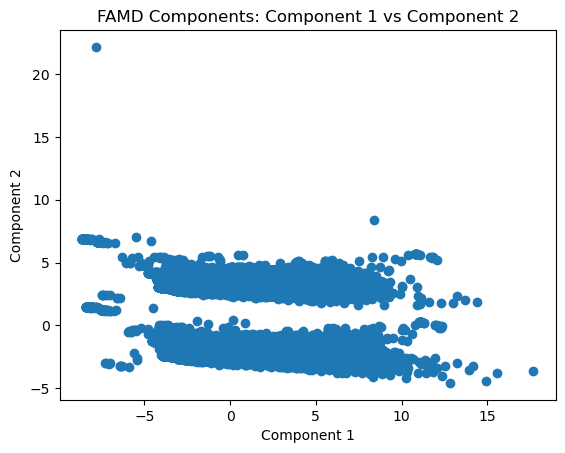

In [103]:
import matplotlib.pyplot as plt

plt.scatter(df_famd_result.iloc[:, 0], df_famd_result.iloc[:, 1])
plt.title('FAMD Components: Component 1 vs Component 2')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()


We can clearly see two groups 

Lets study the inertia of the reduction to understand better how many componetns we need

In [104]:
famd = FAMD(n_components=9, n_iter=10,random_state=10)
famd_fit=famd.fit(df_famd)

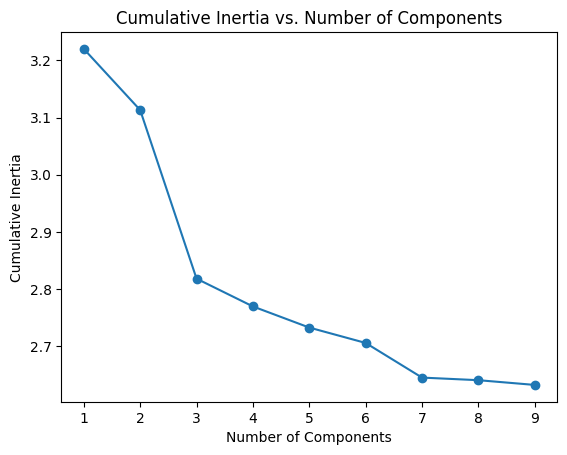

In [ ]:
import pandas as pd
from prince import FAMD
import matplotlib.pyplot as plt


cumulative_inertia = famd_fit.percentage_of_variance_

# We plotting the cumulative inertia
plt.plot(range(1, 10), cumulative_inertia, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Inertia')
plt.title('Cumulative Inertia vs. Number of Components')
plt.show()

We see that we have an elbow for number of components equal 3.

Lets plot all the combination of the components to see if we have more groups formed.

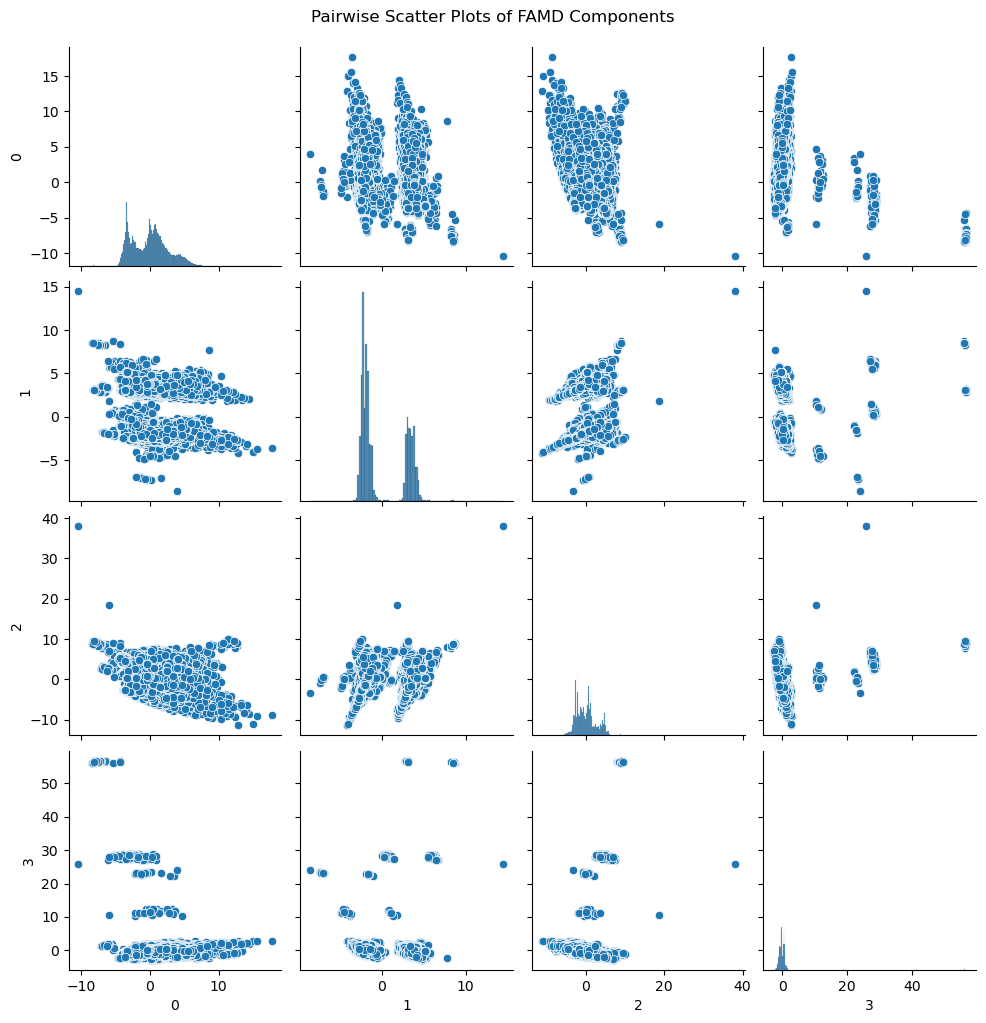

In [105]:
from prince import FAMD
import seaborn as sns
import matplotlib.pyplot as plt


famd = FAMD(n_components=4, n_iter=10,random_state=10)
famd_result = famd.fit_transform(df_famd)

# We acces the transformed data 
transformed_data = famd_result.iloc[:, :4]

# We plot pairwise 
sns.pairplot(transformed_data)
plt.suptitle('Pairwise Scatter Plots of FAMD Components', y=1.02)
plt.show()

Here we can see that depending on the components of the FAMD we want to use we will get more or less groups when we cluster the data.

We may have some things with:

Component 0 and 1,

component 1 and 2.

Component 0 and 3, eventhought we have a lot of small groups that may not be as good.



## 3. Bonus Question

Density-based clustering identifies clusters as regions in the data space with high point density that are separated from other clusters by regions of low point density. The data points in the separating regions of low point density are typically considered noise or outliers. Typical algorithms that fall into this category are OPTICS and DBSCAN.

For the density-based clustering we are going to use the same df_famd_result data we got from the 2.2. We are also only going to get the first 3 components of the datset, being these one the usefull for the clustering.

In [106]:
df_dbscan = df_famd_result.iloc[:, :3]

Lets use now the DBSCAN on the dataset.

In the Dbscan the epsilon paramter indicates the maximum distance between two samples for one to be considered in the neighborhood of the other. It essentially specifies the radius of the neighborhood around a data point.

On the other side the min_samples parameter sets the minimum number of samples in a neighborhood for a point to be considered a core point.
Changing these parameters will change our number of cluster we will have.

We can try with eps = 0.4 and min value = 15

Number of clusters: 21


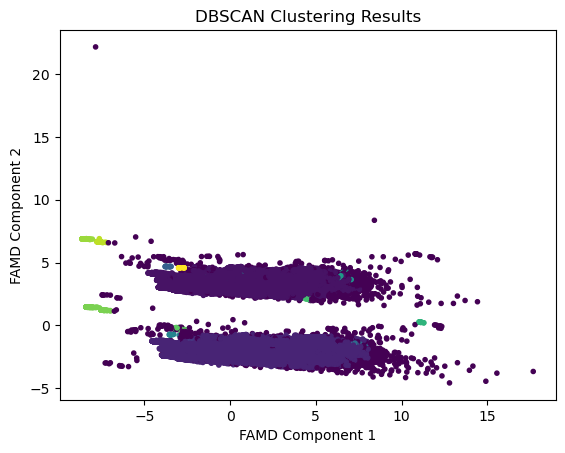

In [107]:
import pandas as pd
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt

# We select a value for eps and might need to adjust the parameters based on your data characteristics
eps_value = 0.4
min_value = 15
dbscan = DBSCAN(eps=eps_value, min_samples=min_value)
labels = dbscan.fit_predict(df_dbscan)

print(f"Number of clusters: {len(set(labels))}")

# We isualize the clusters 
plt.scatter(df_dbscan.iloc[:, 0], df_dbscan.iloc[:, 1], c=labels, cmap='viridis', marker='.')
plt.title('DBSCAN Clustering Results')
plt.xlabel('FAMD Component 1')
plt.ylabel('FAMD Component 2')
plt.show()


Here we have 18 cluster, and is a bit messy when we look at it. Lets try some different values to see how it changes and try to get a better result.

In [108]:
from sklearn.cluster import DBSCAN

# We select different values for eps and min_samples
eps_values = [0.1, 0.5, 1.0]
min_samples_values = [5, 10, 30]

# We run all the values
for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(df_dbscan)
        
        print(f"eps={eps}, min_samples={min_samples}, Number of clusters: {len(set(labels))}")


eps=0.1, min_samples=5, Number of clusters: 770
eps=0.1, min_samples=10, Number of clusters: 383
eps=0.1, min_samples=30, Number of clusters: 125
eps=0.5, min_samples=5, Number of clusters: 25
eps=0.5, min_samples=10, Number of clusters: 14
eps=0.5, min_samples=30, Number of clusters: 8
eps=1.0, min_samples=5, Number of clusters: 12
eps=1.0, min_samples=10, Number of clusters: 8
eps=1.0, min_samples=30, Number of clusters: 5


We can clearly see how it changes, and how there is less clusters when the higher the eps and min_samples. 

This makes sense since the greater the values of the parameters, more samples it will take in it cluster.

Lets plot the last value of 5 clusters to see how it is represnted.

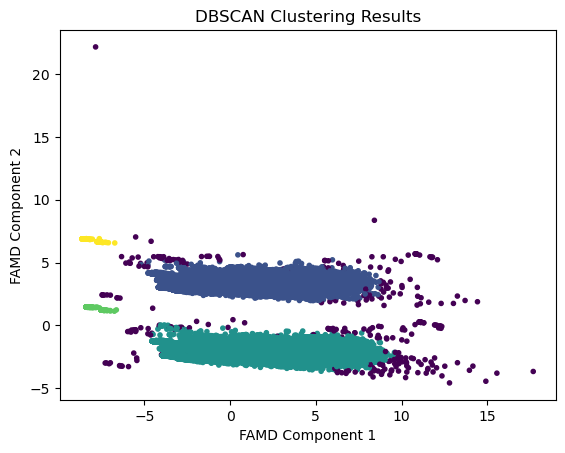

In [109]:
plt.scatter(df_dbscan.iloc[:, 0], df_dbscan.iloc[:, 1], c=labels, cmap='viridis', marker='.')
plt.title('DBSCAN Clustering Results')
plt.xlabel('FAMD Component 1')
plt.ylabel('FAMD Component 2')
plt.show()

Here we can see two main groups that make sense with the distribution we have. We can also see two little cluster (yello and green) that are kind of similar.



A good point to notice is that eventhougth we have a lot of different variables we do have two groups that stand out. This look kind of surprinsing to us, that we expected a bigger amount of clusters

### Comparison with the 2.3-2.4

## 4. Command Line Question
In this section we present the results obtained from the "CommandLine.sh" script. To learn more about the code and understand the implementation details, please refer to the file "Commandline.sh."

1) Most-Watched Netflix Title<br>
To determine the most-watched Netflix title, we calculated the total duration spent on each movie. The script then sorted the results, extracted information about the ID of the most-watched movie, and finally printed the title along with the hours spent watching it.

2) Average Time Between Subsequent Clicks on Netflix.com<br>
For this question, we computed the average time between subsequent clicks on Netflix.com. Each duration in the dataset represents the time between two consecutive clicks of the user, and the average was derived from these durations.

3) User with the Most Time Spent on Netflix<br>
Similar to the approach taken for the first question, we computed the total duration spent by each user. The script then sorted the sum of durations in descending order, allowing us to identify and print the user ID and the hours spent by the top user.

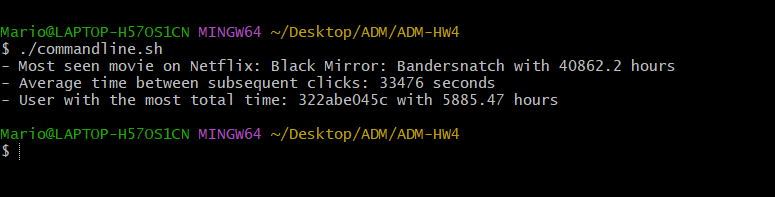

## 5. Algorithmic Question

a) Fortunately, you have a computer app designed by a brilliant student. Federico wants you to show him the code which this app is based on because he wants to do paid counseling for other desperate students: in a recursive fashion, the helped helps the helpable.

In the first algorithm we use brute force since we do all possible permutations of the list of scores in input and compute the final score for each of them; the maximum score will be the greatest value computed among all the permutations.

In [1]:
from itertools import permutations

def calculate_max_score(initial_score, scores):
    max_score = 0
    
    for permutation in permutations(scores): # bottleneck: O(N!)
        i = 0
        S = initial_score

        while i < len(permutation): # O(N^2)
            p = permutation[i]
            permutation = tuple(x - (p - S) for x in permutation)
            S = p
            i += 1
    
        if S > max_score:
            max_score = S  
           
    return max_score

def final_score():
    initial_score = int(input())
    list_scores = list(map(int, input().split()))

    result = calculate_max_score(initial_score, list_scores)
    return result

Example: Input 2

In [2]:
final_score()

25
18 24 21 32 27


44

b) Federico is getting angry because he claims that your code is slow! Show him formally with a big-O notation that he is as crazy as this university!

In this case Federico is right.
Let $N$ be the input size, so the cost of the algorithm is $O(N!N^2)$ due to the permutations computing.
In fact let see the algorithm step by step:


def calculate_max_score(initial_score, scores):
    
    max_score = 0                             O(1)
    
    for permutation in permutations(scores):  O(N!)
        i = 0                                 O(1)
        S = initial_score                     O(1)

        while i < len(permutation):           O(N)
            p = permutation[i]                O(1)
            permutation = tuple(x - (p - S) for x in permutation)   O(N)
            S = p                                                   O(1)
            i += 1                                                  O(1)
    
        if S > max_score:          O(1)
            max_score = S          O(1)
           
    return max_score

So for each permutation we have a cost of $O(N^2)$ since the while loop does $N$ iterations and for each of them we update the elements of the tuple $O(N)$.
In conclusion we have $O(N!N^2)$.

This implementation can be used if the size of the input list is very small, for example it performs very well for the first two given inputs, but when the size increases, as it does in the third input where there are 12 elements, the cost becomes O(12!), so it would require about 480 million iterations to find the final value.

c) If, unfortunately, Federico is right in the grip of madness, he will threaten you to optimize the code through a different approach. You should end this theater of the absurd by any means! (And again, formally prove that you improved time complexity)

The new algorithm is way much faster because it basically needs just to sort the $N$ elements and then spits out the maximum score.

In [3]:
import math

def calculate_max_score(initial_score, list_scores):
    N = len(list_scores)
    num_pos = math.ceil(N / 2)

    sorted_list = sorted(list_scores, reverse=True) # sort the scores list in decreasing order

    good_marks = sorted_list[:num_pos]
    bad_marks = sorted_list[num_pos:]

    final_score = sum(good_marks) - sum(bad_marks)

    if N % 2 == 0:
        final_score += initial_score

    return final_score


def final_score():
    initial_score = int(input())
    list_scores = list(map(int, input().split()))

    result = calculate_max_score(initial_score, list_scores)
    return result

Example: Input 2

In [4]:
final_score()

25
18 24 21 32 27


44

Example_ Input 3

In [5]:
final_score()

30
13 27 41 59 28 33 39 19 52 48 55 79


205

In the new algorithm the critical operation is the sorting, done using the sorted function, which has a time complexity of $O(N log N)$. The subsequent operations (slicing and summing) have linear time complexity, making the overall time complexity $O(N log N)$; in fact the sorting is implemented by Python with a variant of the Merge Sort algorithm.
Let see it in the specific steps:


def calculate_max_score(initial_score, list_scores):
    
    N = len(list_scores)                     O(1)
    num_pos = math.ceil(N / 2)               O(1)

    sorted_list = sorted(list_scores, reverse=True)   O(NlogN)

    good_marks = sorted_list[:num_pos]                O(N)
    bad_marks = sorted_list[num_pos:]                 O(N)

    final_score = sum(good_marks) - sum(bad_marks)    O(N)

    if N % 2 == 0:                                 O(1)
        final_score += initial_score               O(1)

    return final_score

Now we provide a brief proof (done by ourselves) of the correctness of our algorithm.

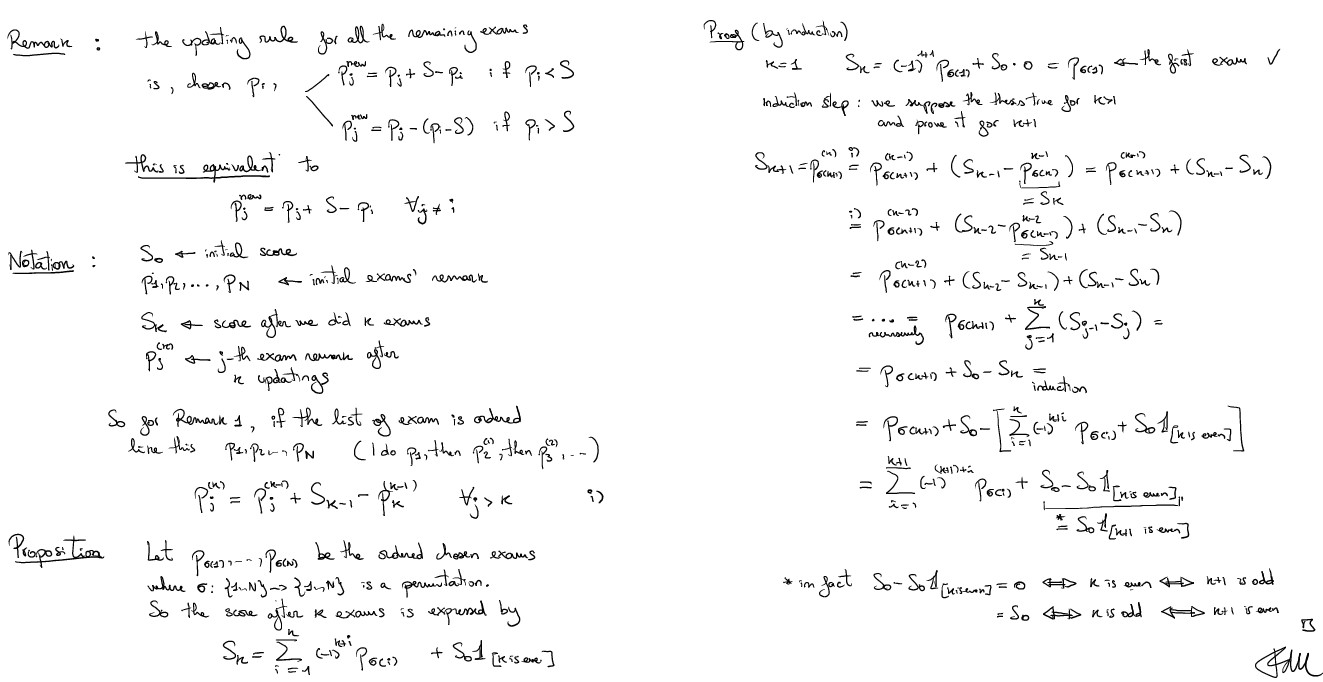

Since the score $S_k$ at step $k$ is provided by the expression above, we can maximize it taking a permutation of the initial exams marks for which the $N/2$ highest exams marks has $+1$ in the expression and $-1$ for the others.

d) Ask chatGPT for a third (optimized) implementation and analyze again its time complexity. Be careful (and crafty) in defining the prompt, and challenge the machine in this coding question!

After several tries where chatGPT failed understanding the task, it has come up with the same "naive" algorithm as the point a). So the implementation has time complexity $O(N!N^2)$.